# Workpackage: Model Engineering

Research Question:
**Can we get a more robust system by splitting the image recognition into more specific subtasks? i.e. using transfer learing**

Research Answer:
The motivation/reason behind using transfer learning is, that we noticed that the training dataset matches neither our validation dataset nor our custom dataset, which results in a bad performance. Problem is that the validation and test dataset are very divers, while our training dataset consists of many very similar photos. We concluded that either we create our own training dataset, which will be time consuming and runs into the problem, that the unknown training dataset will be different again and thus running in a similar problem. The approach to solve that problem is to use a pretrained model that can segment hands from everything else in the background and by that making the pictures in the different datasets more similar to each other. By that in our hypothesis the performance shall improve noticably. Unfortunatly we ran out of time finding such a pretrained model. The ones we found did not hold what they promised and were not robust at all, and others would we need to train ourselfes, which would require days and lots of energy.
**In summary we tried using transfer learning to improve the performance, but were stopped because we could not find a suiting pretrained model.**

In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential



Total images: 9932


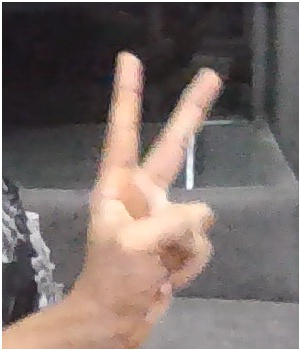

In [2]:
data_dir = pathlib.Path('../Dataset/structured_data')
validation_dir = pathlib.Path('../Dataset/validation_set')
image_count = len(list(data_dir.glob('*/*')))
print("Total images: " +str(image_count))

rock_images = list(data_dir.glob('rock/*'))
paper_images = list(data_dir.glob('paper/*'))
scissors_images = list(data_dir.glob('scissors/*'))

PIL.Image.open(str(scissors_images[1]))

In [3]:
batch_size = 32
img_height = 60
img_width = 60


train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    color_mode='grayscale',
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    validation_split=0.9999,
    subset="validation",
    seed=123,
    color_mode='grayscale',
    image_size=(img_height, img_width),
    batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 9931 files belonging to 3 classes.
Using 7945 files for training.
Found 151 files belonging to 3 classes.
Using 150 files for validation.
['paper', 'rock', 'scissors']


2023-01-30 14:31:16.995428: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


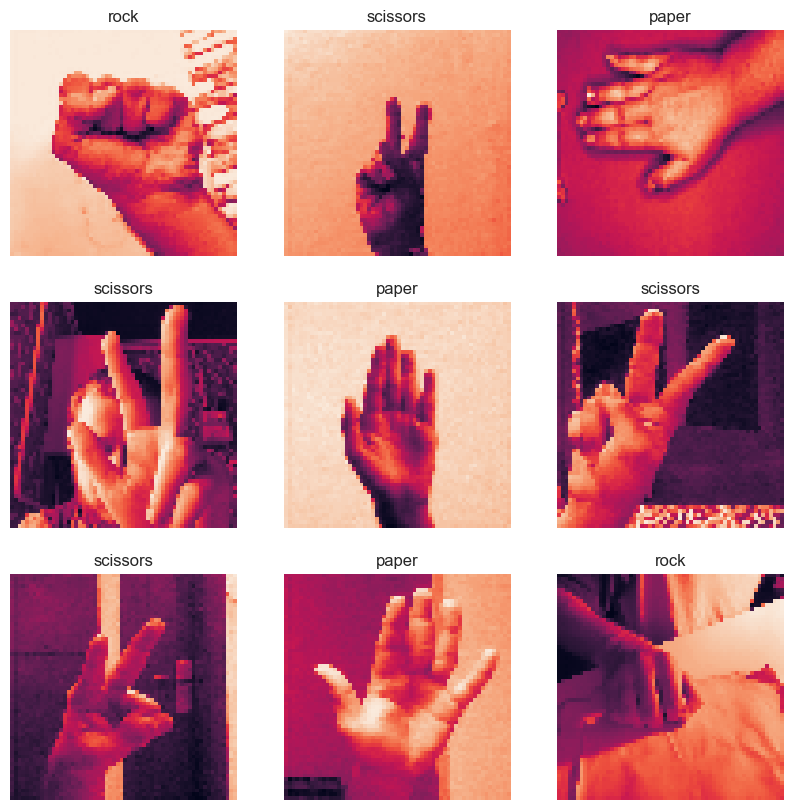

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.011764707 1.0


In [6]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal",
                          input_shape=(img_height,
                                       img_width,
                                       1)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

In [7]:
num_classes = len(class_names)

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])



model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 60, 60, 1)         0         
                                                                 
 rescaling_1 (Rescaling)     (None, 60, 60, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 60, 60, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                  

In [9]:
epochs = 1
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

249/249 [==============================] - 66s 259ms/step - loss: 0.9463 - accuracy: 0.5306 - val_loss: 1.2009 - val_accuracy: 0.4667


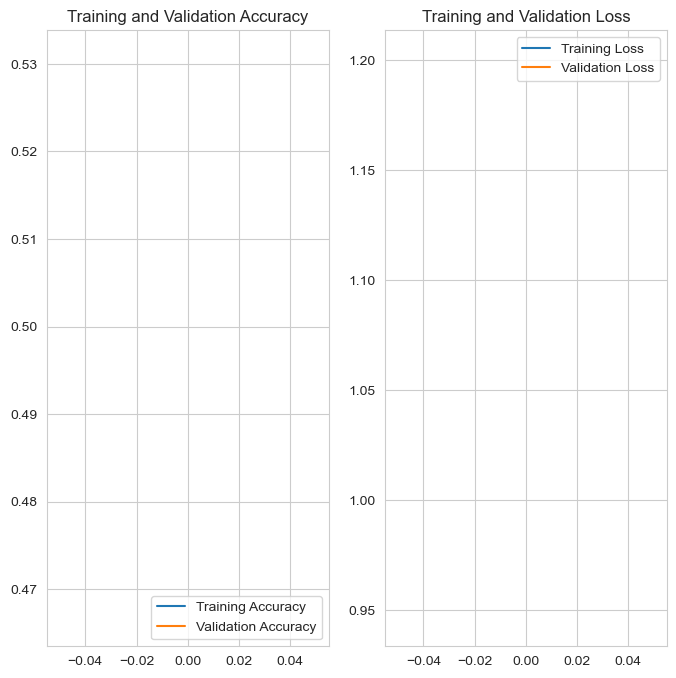

In [10]:
model.save("test.h5")

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os, sys, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import glob
import torch

gpu_available = torch.cuda.is_available()
print('Using Pytorch version: %s. GPU %s available' % (torch.__version__, "IS" if gpu_available else "is NOT"))
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchsummary import summary
from torchvision import transforms
from tensorflow.keras.preprocessing.image import *
import python_toolkit as pytk
# My helper functions for training/evaluating etc.

MODEL_SAVE_DIR = os.path.join('.','model_states')
if not os.path.exists(MODEL_SAVE_DIR):
    os.mkdir(MODEL_SAVE_DIR)
print('MODEL_SAVE_DIR = %s' % MODEL_SAVE_DIR)
np.set_printoptions(precision=6, linewidth=1024, suppress=True)
plt.style.use('seaborn')
sns.set_style('darkgrid')
sns.set_context('notebook',font_scale=1.10)


Using Pytorch version: 1.13.0. GPU is NOT available
MODEL_SAVE_DIR = ./model_states


In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED);
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
CLASSES = ['rock', 'paper', 'scissors']


In [3]:
import os
from PIL import Image

def load_images(paths):
    images = []
    labels = []
    for i, path in enumerate(paths):
        for file in os.listdir(path):
            if file.endswith(".png"):
                img = Image.open(os.path.join(path, file)).convert('L') # converts image to grayscale
                img = img.resize((32, 32)) # resize image
                images.append(img)
                labels.append(i)
    data = list(zip(images, labels))
    random.seed(SEED)
    random.shuffle(data)
    images, labels = zip(*data)
    return np.asarray(images), np.asarray(labels)



In [4]:
def build_model():
    net = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=5, padding=1), # 20
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2,2),
        nn.Dropout(0.4),

        nn.Conv2d(32, 64, kernel_size=5, padding=1), # 32
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2,2),
        nn.Dropout(0.4),

        nn.Conv2d(64, 64, kernel_size=5, padding=1), # 32
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2,2),
        nn.Dropout(0.4),

        nn.Flatten(),

        nn.Linear(64*2*2, 500),
        nn.ReLU(),
        nn.Dropout(0.4),

        nn.Linear(500, 3)
    )

    model = pytk.PytkModuleWrapper(net)
    # add weights to optimizer due to class imbalance
    # weights = torch.FloatTensor(class_counts) / total
    # weights = weights.cuda() if torch.cuda.is_available() else weights.cpu()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(params=model.parameters(), lr=0.001)
    #optimizer = optim.SGD(params=model.parameters(), lr=0.001)
    model.compile(loss=criterion, optimizer=optimizer, metrics=['acc'])
    return model

In [5]:
from sklearn.model_selection import train_test_split
import path
images, labels = load_images(["../Dataset/structured_data/rock", "../Dataset/structured_data/paper", "../Dataset/structured_data/scissors"])
# split dataset into train/test sets in 70:30 ration
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3,
                                                    random_state=SEED, stratify=labels)
# split the test set into cross-val & test datasets in 80:20 rstio
# NOTE: Andrew Ng recommends that, if possible, the test & cv datasets should be drawn
# from the same sample
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.3,
                                                random_state=SEED, stratify=y_test)

print(f"X_train.shape: {X_train.shape} - y_train.shape: {y_train.shape} - class dist: {np.bincount(y_train)}\n" +
      f"X_val.shape: {X_val.shape} - y_val.shape: {y_val.shape} - class dist: {np.bincount(y_val)}\n" +
      f"X_test.shape: {X_test.shape} - y_test.shape: {y_test.shape} - class dist: {np.bincount(y_test)}")

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')
y_val = y_val.astype('float32')

X_train.shape: (3177,) - y_train.shape: (3177,) - class dist: [1058 1062 1057]
X_val.shape: (953,) - y_val.shape: (953,) - class dist: [318 318 317]
X_test.shape: (409,) - y_test.shape: (409,) - class dist: [136 137 136]


In [6]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class RPSDataset(Dataset):
    def __init__(self, x, y, transforms=None):
        self.x = x
        self.y = torch.LongTensor(y)
        self.transforms = transforms

    def __len__(self):
        return len(self.x)

    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        if self.transforms is not None:
            x = self.transforms(x)
        return x, y

train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomAffine(0, shear=0.2),         # random shear 0.2
    transforms.RandomAffine(0, scale=(0.8, 1.2)),  # random zoom 0.2
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

image_transforms = transforms.Compose([
    transforms.ToTensor()
])

In [7]:
train_dataset = RPSDataset(X_train, y_train, train_transforms)
val_dataset = RPSDataset(X_val, y_val, image_transforms)
test_dataset = RPSDataset(X_test, y_test, image_transforms)

In [8]:
model = build_model()
print(model.summary((1, 32, 32)))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 30, 30]          832
├─ReLU: 1-2                              [-1, 32, 30, 30]          --
├─BatchNorm2d: 1-3                       [-1, 32, 30, 30]          64
├─MaxPool2d: 1-4                         [-1, 32, 15, 15]          --
├─Dropout: 1-5                           [-1, 32, 15, 15]          --
├─Conv2d: 1-6                            [-1, 64, 13, 13]          51,264
├─ReLU: 1-7                              [-1, 64, 13, 13]          --
├─BatchNorm2d: 1-8                       [-1, 64, 13, 13]          128
├─MaxPool2d: 1-9                         [-1, 64, 6, 6]            --
├─Dropout: 1-10                          [-1, 64, 6, 6]            --
├─Conv2d: 1-11                           [-1, 64, 4, 4]            102,464
├─ReLU: 1-12                             [-1, 64, 4, 4]            --
├─BatchNorm2d: 1-13                      [-1, 64, 4, 4]            128
├─M

In [9]:
hist = model.fit_dataset(train_dataset, epochs=10, batch_size=32,
                         validation_dataset=val_dataset)

Training on CPU...
Training on 3177 samples, cross-validating on 953 samples


RuntimeError: Predictions and targets are expected to have the same shape, but got torch.Size([32, 3]) and torch.Size([32]).